In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.datasets import make_regression

In [2]:
# this is our target?
y_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
y_CME3MSOFR = y_CME3MSOFR.dropna(axis="columns")
y_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
y_CME3MSOFR.columns = ["date", "rate_CME3MSOFR"]
y_CME3MSOFR["date"] = pd.to_datetime(y_CME3MSOFR["date"])
# flip it so that first row
y_CME3MSOFR = y_CME3MSOFR.iloc[::-1]
y_CME3MSOFR.reset_index(inplace=True)
y_CME3MSOFR = y_CME3MSOFR.drop(columns=["index"])
y_CME3MSOFR.set_index("date", inplace=True)
print(y_CME3MSOFR.head())

            rate_CME3MSOFR
date                      
2019-01-03          2.4328
2019-01-04          2.4296
2019-01-07          2.4276
2019-01-08          2.4298
2019-01-09          2.4390


In [3]:
# this is our feature
# USTbill3M
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
x_USTbill3M.set_index("date", inplace=True)
print(x_USTbill3M.head())

            rate_USTbill3M
date                      
2018-11-26          2.3775
2018-11-27          2.3771
2018-11-28          2.3704
2018-11-29          2.3616
2018-11-30          2.3654


            price_3MSOFRFuture
date                          
2018-12-14              97.370
2018-12-17              97.405
2018-12-18              97.455
2018-12-19              97.460
2018-12-20              97.470


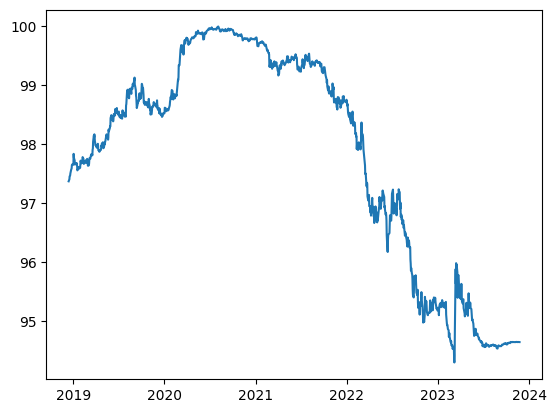

In [4]:
# this is our feature
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
x_3MSOFRFuture.reset_index(inplace=True)
x_3MSOFRFuture = x_3MSOFRFuture.drop(columns=["index"])
x_3MSOFRFuture.set_index("date", inplace=True)
print(x_3MSOFRFuture.head())
plt.plot(x_3MSOFRFuture["price_3MSOFRFuture"])

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


           rate_type  rate_bgcr  vol_billion_usd
date                                            
2018-04-02      BGCR       1.77              361
2018-04-03      BGCR       1.81              344
2018-04-04      BGCR       1.70              348
2018-04-05      BGCR       1.70              349
2018-04-06      BGCR       1.70              352


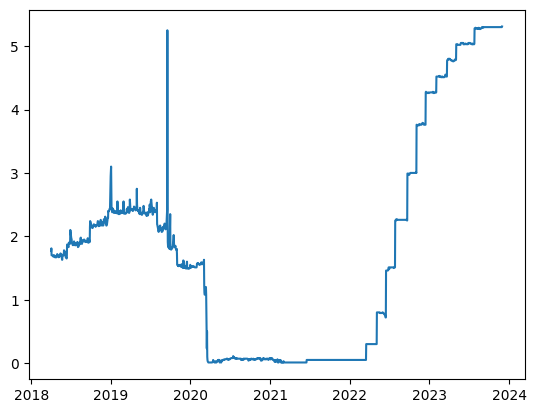

In [5]:
# this is our feature
# bgcr
x_bgcr = pd.read_excel(f"../data/bgcr.xlsx")
x_bgcr = x_bgcr.dropna(axis="columns")
# flip it so that first row
x_bgcr = x_bgcr.iloc[::-1]
x_bgcr.reset_index(inplace=True)
x_bgcr = x_bgcr.drop(columns=["index"])
x_bgcr.columns = ["date", "rate_type", "rate_bgcr", "vol_billion_usd"]
x_bgcr["date"] = pd.to_datetime(x_bgcr["date"])
x_bgcr.set_index("date", inplace=True)
print(x_bgcr.head())
plt.plot(x_bgcr["rate_bgcr"])

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


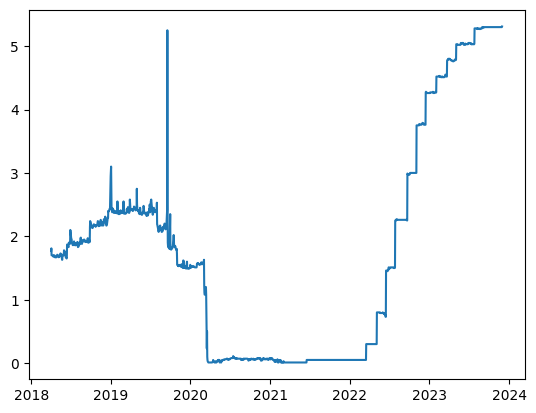

In [6]:
# this is our feature
# tgcr
x_tgcr = pd.read_excel(f"../data/tgcr.xlsx")
x_tgcr = x_tgcr.dropna(axis="columns")
# flip it so that first row
x_tgcr = x_tgcr.iloc[::-1]
x_tgcr.reset_index(inplace=True)
x_tgcr = x_tgcr.drop(columns=["index"])
x_tgcr.columns = ["date", "rate_type", "rate_tgcr", "vol_billion_usd"]
x_tgcr["date"] = pd.to_datetime(x_tgcr["date"])
x_tgcr.set_index("date", inplace=True)
plt.plot(x_tgcr["rate_tgcr"])

In [7]:
# this is our feature
# vix ?
x_vix = pd.read_csv(f"../data/vix.csv")
# flip it so that first row
x_vix.fillna(method="bfill", inplace=True)
x_vix["Date"] = pd.to_datetime(x_vix["Date"])
x_vix.set_index("Date", inplace=True)
x_vix

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-26,20.780001,20.799999,18.670000,18.900000,18.900000,0.0
2018-11-27,19.410000,19.930000,18.700001,19.020000,19.020000,0.0
2018-11-28,18.870001,19.379999,18.180000,18.490000,18.490000,0.0
2018-11-29,18.650000,20.480000,18.590000,18.790001,18.790001,0.0
2018-11-30,19.180000,19.910000,18.030001,18.070000,18.070000,0.0
...,...,...,...,...,...,...
2023-11-20,14.260000,14.310000,13.390000,13.410000,13.410000,0.0
2023-11-21,13.450000,14.310000,13.130000,13.350000,13.350000,0.0
2023-11-22,13.080000,13.250000,12.820000,12.850000,12.850000,0.0


In [8]:
# this is our feature
# sofrdaily
x_sofrdaily = pd.read_excel(f"../data/sofrdaily.xlsx")
x_sofrdaily = x_sofrdaily.dropna(axis="columns")
# flip it so that first row
x_sofrdaily = x_sofrdaily.iloc[::-1]
x_sofrdaily.reset_index(inplace=True)
x_sofrdaily = x_sofrdaily.drop(columns=["index"])
x_sofrdaily.columns = ["date", "rate_type", "rate_sofrdaily", "vol_billion_usd"]
x_sofrdaily["date"] = pd.to_datetime(x_sofrdaily["date"])
x_sofrdaily.set_index("date", inplace=True)
x_sofrdaily

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,rate_type,rate_sofrdaily,vol_billion_usd
date,,,
2018-04-02,SOFR,1.80,849
2018-04-03,SOFR,1.83,825
2018-04-04,SOFR,1.74,859
2018-04-05,SOFR,1.75,829
2018-04-06,SOFR,1.75,845
...,...,...,...
2023-11-24,SOFR,5.32,1521
2023-11-27,SOFR,5.32,1602
2023-11-28,SOFR,5.32,1593


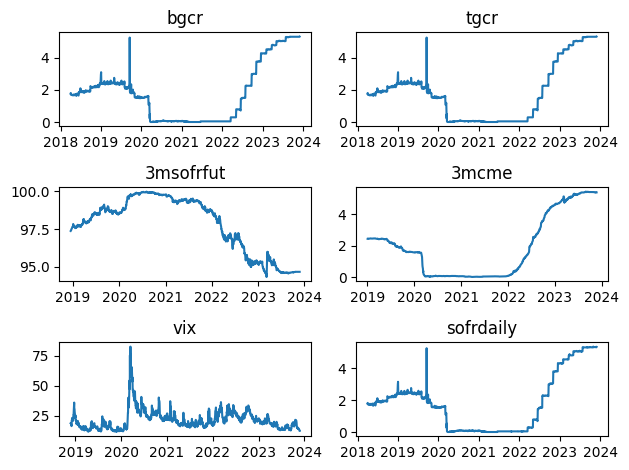

In [9]:
#
plt.subplot(321)
plt.title("bgcr")
plt.plot(x_bgcr["rate_bgcr"])
plt.subplot(322)
plt.title("tgcr")
plt.plot(x_tgcr["rate_tgcr"])
plt.subplot(323)
plt.title("3msofrfut")
plt.plot(x_3MSOFRFuture["price_3MSOFRFuture"])
plt.subplot(324)
plt.title("3mcme")
plt.plot(y_CME3MSOFR["rate_CME3MSOFR"])
plt.subplot(325)
plt.title("vix")
plt.plot(x_vix["Close"])
plt.subplot(326)
plt.title("sofrdaily")
plt.plot(x_sofrdaily["rate_sofrdaily"])
plt.tight_layout()
plt.show()

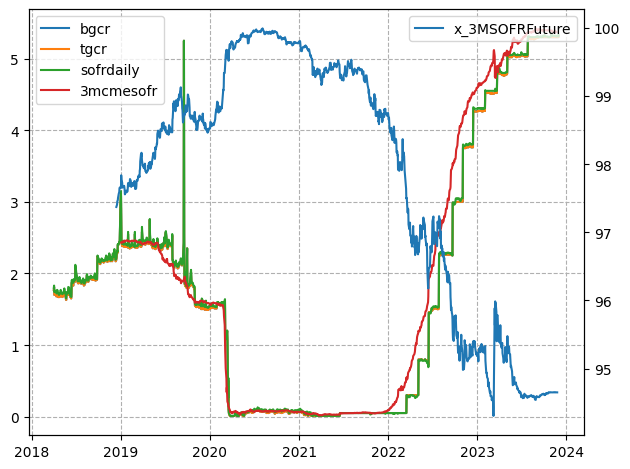

In [10]:
# all together
fig, ax1 = plt.subplots()

ax1.plot(x_bgcr["rate_bgcr"], label="bgcr")
ax1.plot(x_tgcr["rate_tgcr"], label="tgcr")
ax1.plot(x_sofrdaily["rate_sofrdaily"], label="sofrdaily")
# plt.plot(x_3MSOFRFuture["x_price_3MSOFRFuture"], label="3mfut")
ax1.plot(y_CME3MSOFR["rate_CME3MSOFR"], label="3mcmesofr")
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(x_3MSOFRFuture["price_3MSOFRFuture"], label="x_3MSOFRFuture")
ax2.legend()
ax1.grid(linestyle="dashed")
plt.tight_layout()
plt.show()

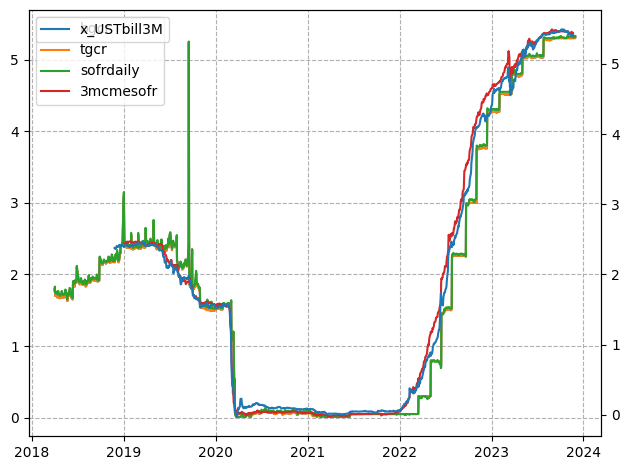

In [11]:
# all together
fig, ax1 = plt.subplots()

ax1.plot(x_bgcr["rate_bgcr"], label="bgcr")
ax1.plot(x_tgcr["rate_tgcr"], label="tgcr")
ax1.plot(x_sofrdaily["rate_sofrdaily"], label="sofrdaily")
# plt.plot(x_3MSOFRFuture["x_price_3MSOFRFuture"], label="3mfut")
ax1.plot(y_CME3MSOFR["rate_CME3MSOFR"], label="3mcmesofr")
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(x_USTbill3M["rate_USTbill3M"], label="x_USTbill3M")
ax2.legend()
ax1.grid(linestyle="dashed")
plt.tight_layout()
plt.show()

In [12]:
# lets give it a shot ?
df = x_sofrdaily.copy()

In [13]:
to_concat = [x_3MSOFRFuture, y_CME3MSOFR, x_bgcr, x_tgcr, x_USTbill3M]
for frames in to_concat:
    df = pd.merge(df, frames, on="date", how="left")
    print(df.isna().sum())
print(df.describe())

rate_type               0
rate_sofrdaily          0
vol_billion_usd         0
price_3MSOFRFuture    181
dtype: int64
rate_type               0
rate_sofrdaily          0
vol_billion_usd         0
price_3MSOFRFuture    181
rate_CME3MSOFR        221
dtype: int64
rate_type_x             0
rate_sofrdaily          0
vol_billion_usd_x       0
price_3MSOFRFuture    181
rate_CME3MSOFR        221
rate_type_y             0
rate_bgcr               0
vol_billion_usd_y       0
dtype: int64
rate_type_x             0
rate_sofrdaily          0
vol_billion_usd_x       0
price_3MSOFRFuture    181
rate_CME3MSOFR        221
rate_type_y             0
rate_bgcr               0
vol_billion_usd_y       0
rate_type               0
rate_tgcr               0
vol_billion_usd         0
dtype: int64
rate_type_x             0
rate_sofrdaily          0
vol_billion_usd_x       0
price_3MSOFRFuture    181
rate_CME3MSOFR        221
rate_type_y             0
rate_bgcr               0
vol_billion_usd_y       0
rate_type   

In [14]:
rows_with_na = df[df.isna().any(axis=1)]
rows_with_na

,rate_type_x,rate_sofrdaily,vol_billion_usd_x,price_3MSOFRFuture,rate_CME3MSOFR,rate_type_y,rate_bgcr,vol_billion_usd_y,rate_type,rate_tgcr,vol_billion_usd,rate_USTbill3M
date,,,,,,,,,,,,
2018-04-02,SOFR,1.80,849,NaN,NaN,BGCR,1.77,361,TGCR,1.77,329,NaN
2018-04-03,SOFR,1.83,825,NaN,NaN,BGCR,1.81,344,TGCR,1.81,321,NaN
2018-04-04,SOFR,1.74,859,NaN,NaN,BGCR,1.70,348,TGCR,1.70,327,NaN
2018-04-05,SOFR,1.75,829,NaN,NaN,BGCR,1.70,349,TGCR,1.70,331,NaN
2018-04-06,SOFR,1.75,845,NaN,NaN,BGCR,1.70,352,TGCR,1.70,336,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,SOFR,5.32,1521,94.65,NaN,BGCR,5.30,588,TGCR,5.30,577,NaN
2023-11-27,SOFR,5.32,1602,NaN,NaN,BGCR,5.30,594,TGCR,5.30,582,NaN
2023-11-28,SOFR,5.32,1593,NaN,NaN,BGCR,5.30,594,TGCR,5.30,578,NaN


In [15]:
df.dropna(inplace=True)

In [16]:
df.drop(
    columns=[
        "rate_type_x",
        "vol_billion_usd_x",
        "rate_type_y",
        "vol_billion_usd_y",
        "rate_type",
        "vol_billion_usd",
    ],
    inplace=True,
)
df

,rate_sofrdaily,price_3MSOFRFuture,rate_CME3MSOFR,rate_bgcr,rate_tgcr,rate_USTbill3M
date,,,,,,
2019-01-03,2.70,97.8350,2.43280,2.70,2.70,2.3919
2019-01-04,2.45,97.7700,2.42960,2.43,2.43,2.4058
2019-01-07,2.41,97.7250,2.42760,2.38,2.38,2.4127
2019-01-08,2.42,97.6550,2.42980,2.40,2.40,2.4243
2019-01-09,2.45,97.6650,2.43900,2.44,2.44,2.4213
...,...,...,...,...,...,...
2023-11-14,5.32,94.6500,5.37972,5.30,5.30,5.4014
2023-11-15,5.32,94.6500,5.39021,5.30,5.30,5.4061
2023-11-16,5.32,94.6500,5.36937,5.30,5.30,5.3972


In [17]:
y = df["rate_sofrdaily"].copy()
X = df.drop(
    columns=["rate_sofrdaily", "rate_bgcr", "rate_tgcr", "rate_CME3MSOFR"]
).copy()

#

In [18]:
X.head()

,price_3MSOFRFuture,rate_USTbill3M
date,,
2019-01-03,97.835,2.3919
2019-01-04,97.770,2.4058
2019-01-07,97.725,2.4127
2019-01-08,97.655,2.4243
2019-01-09,97.665,2.4213


In [19]:
y.head()

date
2019-01-03    2.70
2019-01-04    2.45
2019-01-07    2.41
2019-01-08    2.42
2019-01-09    2.45
Name: rate_sofrdaily, dtype: float64

Mutual Information

In [20]:
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

rate_USTbill3M    2.292028
Name: MI Scores, dtype: float64

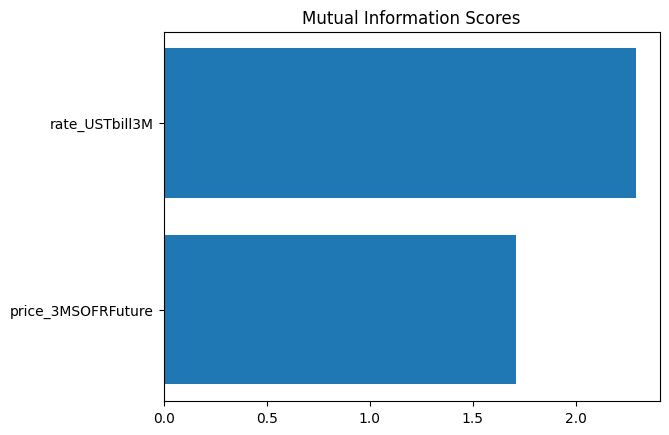

In [21]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100)
plot_mi_scores(mi_scores)

# VIF CHECK #

In [22]:
# Calculate VIF for each predictor variable
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data


# Display the VIF values
vif_results = calculate_vif(X)
print(vif_results)

             Variable       VIF
0  price_3MSOFRFuture  1.850651
1      rate_USTbill3M  1.850651


iseng doang

In [23]:
my_test_size = 100

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=my_test_size, shuffle=False
)

model = LinearRegression()
model.fit(X_train, y_train)
y_fit = pd.Series(
    model.predict(X_train), index=y_train.index
)  # y from predicting using X_train
y_pred = pd.Series(
    model.predict(X_test), index=y_test.index
)  #  y from predicting using X_test

In [25]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

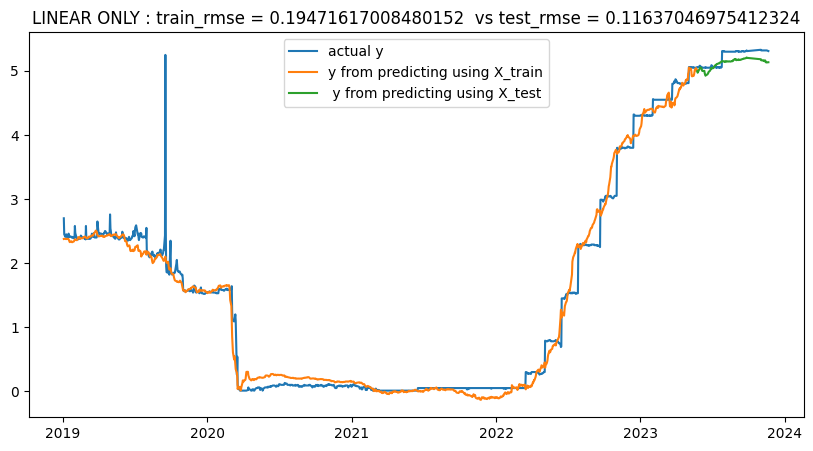

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(y, label="actual y")
plt.plot(y_fit, label="y from predicting using X_train")
# plt.plot(y_cut, label="y_cut")
plt.plot(y_pred, label=" y from predicting using X_test")
plt.title(f"LINEAR ONLY : train_rmse = {train_rmse}  vs test_rmse = {test_rmse}")
plt.legend()